# NLST Demographic Info

Handle the demographic information columns (there's so many) before examining performance.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json

from utilities.info import *
from utilities.predictions import sybil_label

DICT_PATH = f"{INPUT_DIR}/participant_d040722.csv"
FILE_DIR

'C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Data/melba-files-2'

## Load Demographic Info and Choose Rows Based on Patients

Venk21 data. Our main dataset, including validation predictions.

In [84]:
PREDS_PATH = f"{FILE_DIR}/nlst_allmodels.csv"
INCLUDES_VENK21_DATA = True

OUTDEMOS_PATH = f"{FILE_DIR}/nlst_demos.csv"
OUTMERGE_PATH = f"{FILE_DIR}/nlst_allmodels_demos.csv"
OUTCOLS_PATH = f"{FILE_DIR}/nlst_democols.json"

Sybil training data splits. For prevalence checks.

In [85]:
# PREDS_PATH = f"{INPUT_DIR}/sybil-nlst-info/sybil-nlst-splitinfo.csv"
# INCLUDES_VENK21_DATA = False

# OUTDEMOS_PATH = f"{FILE_DIR}/nlst_sybil_demos_patientlevel.csv"
# OUTMERGE_PATH = f"{FILE_DIR}/nlst_sybil_demos.csv"
# OUTCOLS_PATH = f"{FILE_DIR}/nlst_sybil_democols.json"

In [86]:
nlst_preds = pd.read_csv(PREDS_PATH)
nlst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            16077 non-null  int64  
 1   StudyDate            16077 non-null  int64  
 2   SeriesInstanceUID    16077 non-null  object 
 3   CoordX               16077 non-null  float64
 4   CoordY               16077 non-null  float64
 5   CoordZ               16077 non-null  float64
 6   LesionID             16077 non-null  int64  
 7   NoduleType           16077 non-null  object 
 8   Spiculation          16077 non-null  bool   
 9   Diameter_mm          16077 non-null  float64
 10  Age                  16077 non-null  int64  
 11  Gender               16077 non-null  int64  
 12  FamilyHistoryLungCa  16077 non-null  bool   
 13  Emphysema            16077 non-null  bool   
 14  NoduleInUpperLung    16077 non-null  bool   
 15  NoduleCounts         16077 non-null 

In [87]:
nlst_dict_full = pd.read_csv(DICT_PATH)
nlst_dict_full.info()

C:\Users\shaur\AppData\Local\Temp\ipykernel_3512\3010214097.py:1: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  nlst_dict_full = pd.read_csv(DICT_PATH)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53452 entries, 0 to 53451
Columns: 356 entries, cen to evpsent
dtypes: float64(283), int64(64), object(9)
memory usage: 145.2+ MB


In [88]:
df = nlst_dict_full[nlst_dict_full['pid'].isin(nlst_preds['PatientID'])].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Columns: 356 entries, cen to evpsent
dtypes: float64(283), int64(64), object(9)
memory usage: 14.3+ MB


## Choose Demographic Columns

In [89]:
cols = {"num": {}, 'cat': {}}
df['PatientID'] = df['pid']
cols["info"] = ['PatientID', 'study']
df['study'].value_counts(dropna=False)

study
1    3518
2    1023
3     741
Name: count, dtype: int64

Next up we analyze and aggregate the columns since that still leaves us about 140 at the end.

### Demographic columns

In [90]:
col_demo_cat = ['race', 'gender', 'ethnic', 'marital', 'educat']
col_demo_num = ['age', 'height', 'weight']
df[col_demo_cat + col_demo_num].isna().sum()

race        0
gender      0
ethnic      0
marital     1
educat      0
age         0
height      9
weight     12
dtype: int64

In [91]:
print(df['educat'].value_counts(dropna=False))
df['educat'].replace([8, 95, 98, 99], value=np.nan, inplace=True)
print(df['educat'].value_counts(dropna=False))

educat
3     1324
5     1201
6      833
7      757
4      711
2      276
8       88
1       81
99      10
95       1
Name: count, dtype: int64
educat
3.0    1324
5.0    1201
6.0     833
7.0     757
4.0     711
2.0     276
NaN      99
1.0      81
Name: count, dtype: int64


C:\Users\shaur\AppData\Local\Temp\ipykernel_3512\394257443.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['educat'].replace([8, 95, 98, 99], value=np.nan, inplace=True)


In [92]:
df['HS-or-more'] = df['educat'].apply(lambda x: 1 if x >=3 else (0 if x < 3 else None))
col_demo_cat.append('HS-or-more')
df['HS-or-more'].value_counts(dropna=False)

HS-or-more
1.0    4826
0.0     357
NaN      99
Name: count, dtype: int64

In [93]:
df['more-than-HS'] = df['educat'].apply(lambda x: 1 if x >=4 else (0 if x < 4 else None))
col_demo_cat.append('more-than-HS')
df['more-than-HS'].value_counts(dropna=False)

more-than-HS
1.0    3502
0.0    1681
NaN      99
Name: count, dtype: int64

In [94]:
print(df['ethnic'].value_counts(dropna=False))
df['ethnic'].replace([7, 95, 98, 99], value=np.nan, inplace=True)
print(df['ethnic'].value_counts(dropna=False))

ethnic
2     5170
1       79
99      29
7        3
95       1
Name: count, dtype: int64
ethnic
2.0    5170
1.0      79
NaN      33
Name: count, dtype: int64


C:\Users\shaur\AppData\Local\Temp\ipykernel_3512\1743828899.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ethnic'].replace([7, 95, 98, 99], value=np.nan, inplace=True)


In [95]:
print(df['marital'].value_counts(dropna=False))
df['marital'].replace([7, 9], value=np.nan, inplace=True)
print(df['marital'].value_counts(dropna=False))

marital
2.0    3507
5.0    1014
3.0     454
1.0     233
4.0      62
9.0       6
7.0       5
NaN       1
Name: count, dtype: int64
marital
2.0    3507
5.0    1014
3.0     454
1.0     233
4.0      62
NaN      12
Name: count, dtype: int64


C:\Users\shaur\AppData\Local\Temp\ipykernel_3512\1313743828.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['marital'].replace([7, 9], value=np.nan, inplace=True)


In [96]:
print(df['race'].value_counts(dropna=False))
df['race'].replace([7, 95, 96, 98, 99], value=np.nan, inplace=True)
print(df['race'].value_counts(dropna=False))

race
1     4882
2      195
3       93
6       59
4       20
5       19
7        6
99       5
98       1
95       1
96       1
Name: count, dtype: int64
race
1.0    4882
2.0     195
3.0      93
6.0      59
4.0      20
5.0      19
NaN      14
Name: count, dtype: int64


C:\Users\shaur\AppData\Local\Temp\ipykernel_3512\2770304117.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['race'].replace([7, 95, 96, 98, 99], value=np.nan, inplace=True)


In [97]:
df.query('ethnic == 1')['race'].value_counts(dropna=False)

race
1.0    63
NaN     9
2.0     2
6.0     2
3.0     2
4.0     1
Name: count, dtype: int64

In [98]:
df['NonHispanicWhite'] = (df['race'] == 1.0) & (df['ethnic'] == 2.0)
col_demo_cat.append('NonHispanicWhite')
df['NonHispanicWhite'].value_counts(dropna=False)

NonHispanicWhite
True     4798
False     484
Name: count, dtype: int64

In [99]:
df['HighSchoolPlus'] = (df['educat'] != 1.0)
col_demo_cat.append('HighSchoolPlus')
df['HighSchoolPlus'].value_counts(dropna=False)

HighSchoolPlus
True     5201
False      81
Name: count, dtype: int64

In [100]:
df['Married'] = (df['marital'] == 2.0)
col_demo_cat.append('Married')
df['Married'].value_counts(dropna=False)

Married
True     3507
False    1775
Name: count, dtype: int64

In [101]:
def bmi_calc(height, weight):
    return (weight * 703) / (height * height)

df['BMI'] = bmi_calc(height=df['height'], weight=df['weight'])
col_demo_num.append('BMI')
df['BMI'].describe()

count    5265.000000
mean       27.585568
std         5.021753
min        13.284203
25%        24.207989
50%        26.959459
75%        30.341527
max        65.000416
Name: BMI, dtype: float64

In [102]:
df['WhiteOrBlack'] = df['race'].replace([3, 4, 5, 6], value=np.nan, inplace=False)
col_demo_cat.append('WhiteOrBlack')
df['WhiteOrBlack'].value_counts()

WhiteOrBlack
1.0    4882
2.0     195
Name: count, dtype: int64

In [103]:
df['Overweight'] = (df['BMI'] >= 25)
col_demo_cat.append('Overweight')

In [104]:
df['Unfinished_ed'] = (df['educat'] == 2) | (df['educat'] == 5)
col_demo_cat.append('Unfinished_ed')

In [105]:
df[col_demo_cat + col_demo_num].isna().sum()

race                 14
gender                0
ethnic               33
marital              12
educat               99
HS-or-more           99
more-than-HS         99
NonHispanicWhite      0
HighSchoolPlus        0
Married               0
WhiteOrBlack        205
Overweight            0
Unfinished_ed         0
age                   0
height                9
weight               12
BMI                  17
dtype: int64

Age and gender are already included in the Venk21 sheet so we don't need it here as well.

In [106]:
cols['cat']['demo'] = list(set(col_demo_cat) - set(['gender']))
cols['num']['demo'] = list(set(col_demo_num) - set(['age']))

In [107]:
cols

{'num': {'demo': ['weight', 'height', 'BMI']},
 'cat': {'demo': ['HS-or-more',
   'HighSchoolPlus',
   'educat',
   'more-than-HS',
   'Married',
   'Unfinished_ed',
   'WhiteOrBlack',
   'NonHispanicWhite',
   'race',
   'ethnic',
   'marital',
   'Overweight']},
 'info': ['PatientID', 'study']}

### Smoking columns

In [108]:
col_smoke_cat =  ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework']
col_smoke_num = ['pkyr', 'smokeage', 'smokeday', 'smokeyr']
df[col_smoke_cat + col_smoke_num].isna().sum()

cigar        18
cigsmok       0
pipe         35
smokelive    23
smokework    35
pkyr          0
smokeage      0
smokeday      0
smokeyr       0
dtype: int64

Let's not include `age_quit` - too many None values.

In [109]:
pd.DataFrame({c: df[c].value_counts(dropna=False) for c in col_smoke_cat}).drop_duplicates()

,cigar,cigsmok,pipe,smokelive,smokework
0.0,4242,2621.0,4097,614,675
1.0,1022,2661.0,1150,4645,4572
NaN,18,NaN,35,23,35


In [110]:
pd.DataFrame({c: [len(df.query(f'gender == {i} and {c} == 1')) for i in [1,2]] for c in col_smoke_cat}, index=['M','F'])

,cigar,cigsmok,pipe,smokelive,smokework
M,942,1495,1107,2520,2665
F,80,1166,43,2125,1907


In [111]:
cols['cat']['smoke'] = col_smoke_cat
cols['num']['smoke'] = col_smoke_num

### Work history columns

In [112]:
workfacets = ['res', 'wrk', 'yrs']
worktypes = ['asbe', 'baki', 'butc', 'chem', 'coal', 'cott', 'farm', 'fire', 'flou', 'foun', 'hard', 'pain', 'sand', 'weld']
workcols = {f: [f+t for t in worktypes] for f in workfacets}

In [113]:
for t in worktypes:
    hasworked = len(df.query(f'wrk{t} == 1'))
    resnotnull = len(df[~df[f'res{t}'].isna()])
    yrsnotnull = len(df[~df[f'yrs{t}'].isna()])
    print(t, hasworked, resnotnull, yrsnotnull)

asbe 253 246 240
baki 133 132 127
butc 111 109 110
chem 352 333 343
coal 27 26 26
cott 43 41 42
farm 591 566 578
fire 95 93 93
flou 54 53 54
foun 229 219 222
hard 36 34 36
pain 282 274 272
sand 95 90 88
weld 297 287 290


In [114]:
df[workcols['wrk']].sum(axis=1).sort_values(ascending=False)

3427    12.0
3121     8.0
3602     8.0
2343     7.0
1908     7.0
        ... 
2052     0.0
2054     0.0
2056     0.0
2057     0.0
2641     0.0
Length: 5282, dtype: float64

In [115]:
pd.DataFrame({t: df[f'wrk{t}'].value_counts(dropna=False) for t in worktypes})

,asbe,baki,butc,chem,coal,cott,farm,fire,flou,foun,hard,pain,sand,weld
0.0,5024,5148,5170,4927,5254,5238,4689,5186,5227,5052,5245,4999,5186,4984
1.0,253,133,111,352,27,43,591,95,54,229,36,282,95,297
NaN,5,1,1,3,1,1,2,1,1,1,1,1,1,1


In [116]:
pd.DataFrame({t: [len(df.query(f'gender == {i} and wrk{t} == 1')) for i in [1,2]] for t in worktypes}, index=['M','F'])

,asbe,baki,butc,chem,coal,cott,farm,fire,flou,foun,hard,pain,sand,weld
M,234,73,93,235,26,30,454,92,45,210,35,235,82,275
F,19,60,18,117,1,13,137,3,9,19,1,47,13,22


In [117]:
pd.DataFrame({t: df[f'res{t}'].value_counts(dropna=False) for t in worktypes}).drop_duplicates()

,asbe,baki,butc,chem,coal,cott,farm,fire,flou,foun,hard,pain,sand,weld
0.0,205,131.0,107.0,277,22,39.0,549,45,47,190,28,201,41,235
1.0,36,1.0,2.0,51,2,2.0,15,45,5,26,5,69,48,51
2.0,5,NaN,NaN,5,2,NaN,2,3,1,3,1,4,1,1
NaN,5036,5150.0,5173.0,4949,5256,5241.0,4716,5189,5229,5063,5248,5008,5192,4995


In [118]:
for t in worktypes:
    nomask = df[f'res{t}'] == 0
    df[f'wrknomask{t}'] = nomask

df['wrknomask'] = df[[f'wrknomask{t}' for t in worktypes]].any(axis=1)

In [119]:
pd.DataFrame({t: [len(df.query(f'gender == {i} and wrknomask{t} == 1')) for i in [1,2]] for t in worktypes}, index=['M','F'])

,asbe,baki,butc,chem,coal,cott,farm,fire,flou,foun,hard,pain,sand,weld
M,188,72,91,180,21,26,426,44,40,173,28,162,33,219
F,17,59,16,97,1,13,123,1,7,17,0,39,8,16


In [120]:
df['wrknomask'].value_counts()

wrknomask
False    3959
True     1323
Name: count, dtype: int64

In [121]:
df[workcols['res']].iloc[3156]

resasbe    NaN
resbaki    NaN
resbutc    NaN
reschem    NaN
rescoal    NaN
rescott    NaN
resfarm    0.0
resfire    NaN
resflou    NaN
resfoun    NaN
reshard    NaN
respain    2.0
ressand    NaN
resweld    NaN
Name: 3156, dtype: float64

In [122]:
df[workcols['yrs']].describe()

,yrsasbe,yrsbaki,yrsbutc,yrschem,yrscoal,yrscott,yrsfarm,yrsfire,yrsflou,yrsfoun,yrshard,yrspain,yrssand,yrsweld
count,240.000000,127.000000,110.000000,343.000000,26.000000,42.000000,578.000000,93.000000,54.000000,222.000000,36.000000,272.000000,88.000000,290.000000
mean,14.741667,8.259843,9.827273,13.087464,16.076923,7.571429,13.043253,14.752688,9.148148,13.909910,10.277778,10.448529,10.920455,14.420690
std,13.258609,10.830742,11.739418,12.162806,13.962587,9.625025,10.545430,10.478400,11.296029,13.636556,10.188540,11.427822,10.875705,12.957834
min,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,2.000000,2.000000,2.250000,1.000000,5.000000,5.000000,2.000000,3.000000,2.000000,2.000000,2.000000,3.000000
50%,10.000000,3.000000,4.000000,8.000000,16.500000,4.000000,10.000000,12.000000,4.000000,8.000000,6.500000,5.000000,7.500000,10.000000
75%,25.000000,10.000000,14.750000,22.000000,24.500000,7.750000,18.000000,24.000000,9.750000,23.750000,15.250000,15.000000,18.000000,25.000000
max,50.000000,50.000000,50.000000,50.000000,55.000000,40.000000,60.000000,38.000000,47.000000,47.000000,38.000000,50.000000,50.000000,50.000000


<Axes: >

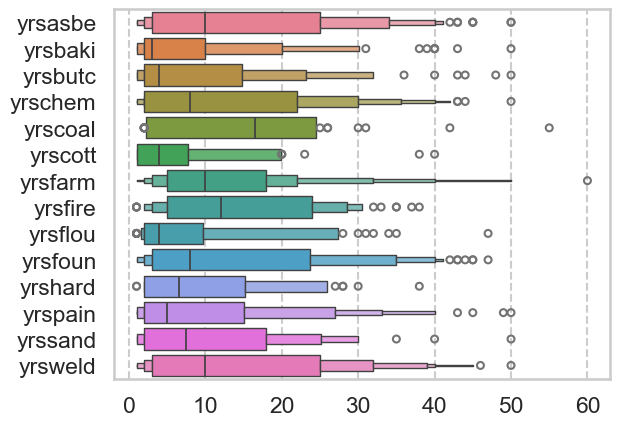

In [123]:
sns.boxenplot(data=df[workcols['yrs']], orient='h')

In [124]:
cols['cat']['work'] = workcols['wrk']

### Disease history columns

In [125]:
diseasefacets = ['age', 'diag']
diseasetypes = ['adas', 'asbe', 'bron', 'chas', 'chro', 'copd', 'diab', 'emph', 'fibr', 'hear', 'hype', 'pneu', 'sarc', 'sili', 'stro', 'tube']

In [126]:
pd.DataFrame({t: df[f'diag{t}'].value_counts(dropna=False) for t in diseasetypes}).drop_duplicates()

,adas,asbe,bron,chas,chro,copd,diab,emph,fibr,hear,hype,pneu,sarc,sili,stro,tube
0.0,4920,5218,5084,5097,4705,4905,4758,4723,5257,4556,3396,4031,5256,5260,5124,5216
1.0,353,57,181,178,561,358,518,546,16,706,1876,1240,13,9,152,60
NaN,9,7,17,7,16,19,6,13,9,20,10,11,13,13,6,6


In [127]:
pd.DataFrame({t: [len(df.query(f'gender == {i} and diag{t} == 1')) for i in [1,2]] for t in diseasetypes}, index=['M','F'])

,adas,asbe,bron,chas,chro,copd,diab,emph,fibr,hear,hype,pneu,sarc,sili,stro,tube
M,111,55,89,104,203,177,341,338,10,521,1123,580,6,7,99,34
F,242,2,92,74,358,181,177,208,6,185,753,660,7,2,53,26


In [128]:
df[[f"age{t}" for t in diseasetypes]].describe()

,ageadas,ageasbe,agebron,agechas,agechro,agecopd,agediab,ageemph,agefibr,agehear,agehype,agepneu,agesarc,agesili,agestro,agetube
count,344.000000,56.000000,151.000000,164.000000,511.000000,339.000000,504.000000,513.000000,15.000000,677.000000,1810.000000,1149.000000,13.000000,9.000000,147.000000,58.000000
mean,49.976744,54.642857,38.357616,6.646341,40.927593,56.982301,54.438492,56.116959,50.866667,54.355982,51.765746,35.375109,48.153846,53.555556,57.455782,28.465517
std,12.838741,7.354476,19.412829,3.939331,17.123446,7.469443,9.963561,8.926455,9.804275,10.431178,10.868191,20.112604,18.045526,12.875472,8.327403,18.714115
min,13.000000,27.000000,1.000000,0.000000,1.000000,30.000000,1.000000,13.000000,25.000000,1.000000,3.000000,1.000000,8.000000,30.000000,21.000000,0.000000
25%,42.750000,50.000000,21.000000,4.000000,30.000000,52.500000,50.000000,51.000000,49.000000,50.000000,46.000000,18.000000,39.000000,54.000000,54.000000,12.750000
50%,53.000000,56.500000,40.000000,6.000000,45.000000,57.000000,56.000000,57.000000,51.000000,56.000000,54.000000,35.000000,54.000000,57.000000,59.000000,25.000000
75%,60.000000,60.000000,55.000000,9.000000,55.000000,62.000000,60.000000,62.000000,56.000000,61.000000,60.000000,54.000000,61.000000,62.000000,62.000000,41.500000
max,72.000000,65.000000,73.000000,17.000000,72.000000,73.000000,73.000000,73.000000,65.000000,74.000000,73.000000,74.000000,69.000000,65.000000,73.000000,68.000000


<Axes: >

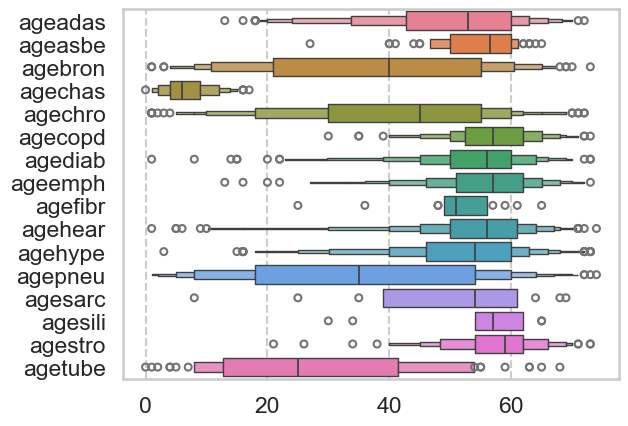

In [129]:
sns.boxenplot(data=df[[f"age{t}" for t in diseasetypes]], orient='h')

In [130]:
cols['cat']['disease'] = [f'diag{t}' for t in diseasetypes]

### Personal cancer history columns

In [131]:
pcancerfacets = ['age', 'canc']
pcancertypes = ['blad', 'brea', 'cerv', 'colo', 'esop', 'kidn', 'lary', 'lung', 'nasa', 'oral', 'panc', 'phar', 'stom', 'thyr', 'tran']

In [132]:
pd.DataFrame({t: df[f'canc{t}'].value_counts(dropna=False) for t in pcancertypes}).drop_duplicates()

,blad,brea,cerv,colo,esop,kidn,lary,lung,nasa,oral,panc,phar,stom,thyr,tran
0.0,5240,5182,5197,5251,5271,5268,5271,5272,5271,5261,5276.0,5275,5270,5265,5271
1.0,35,91,78,25,5,8,5,4,3,14,NaN,1,6,8,1
NaN,7,9,7,6,6,6,6,6,8,7,6.0,6,6,9,10


In [133]:
pd.DataFrame({t: [len(df.query(f'gender == {i} and canc{t} == 1')) for i in [1,2]] for t in pcancertypes}, index=['M','F'])

,blad,brea,cerv,colo,esop,kidn,lary,lung,nasa,oral,panc,phar,stom,thyr,tran
M,31,0,0,14,4,4,5,3,2,9,0,0,4,5,0
F,4,91,78,11,1,4,0,1,1,5,0,1,2,3,1


In [134]:
df[[f"age{t}" for t in pcancertypes]].describe()

,ageblad,agebrea,agecerv,agecolo,ageesop,agekidn,agelary,agelung,agenasa,ageoral,agepanc,agephar,agestom,agethyr,agetran
count,35.000000,91.000000,78.000000,25.000000,5.000000,8.000000,5.000000,4.00,3.000000,14.000000,0.0,1.0,6.000000,8.000000,1.0
mean,55.885714,49.626374,36.538462,53.840000,50.800000,54.625000,55.000000,65.25,62.000000,53.928571,NaN,54.0,47.000000,45.375000,45.0
std,10.303544,8.452019,10.079801,8.979978,6.978539,7.424621,12.629331,4.50,6.244998,9.988180,NaN,NaN,7.071068,11.987345,NaN
min,17.000000,25.000000,21.000000,32.000000,45.000000,48.000000,40.000000,59.00,55.000000,36.000000,NaN,54.0,35.000000,30.000000,45.0
25%,52.000000,43.500000,28.000000,50.000000,46.000000,49.500000,43.000000,63.50,59.500000,50.000000,NaN,54.0,45.000000,36.250000,45.0
50%,56.000000,50.000000,34.500000,55.000000,48.000000,52.000000,60.000000,66.50,64.000000,54.000000,NaN,54.0,47.500000,43.000000,45.0
75%,63.500000,55.500000,41.750000,59.000000,53.000000,57.500000,65.000000,68.25,65.500000,60.750000,NaN,54.0,51.500000,56.250000,45.0
max,68.000000,68.000000,63.000000,67.000000,62.000000,67.000000,67.000000,69.00,67.000000,70.000000,NaN,54.0,55.000000,61.000000,45.0


<Axes: >

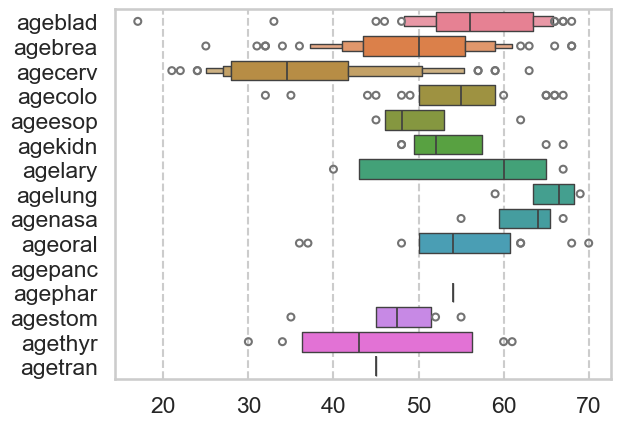

In [135]:
sns.boxenplot(data=df[[f"age{t}" for t in pcancertypes]], orient='h')

In [136]:
cols['cat']['canchist'] = [f"canc{t}" for t in pcancertypes]

In [137]:
df['PersonalCancerHist'] = df[[f"canc{t}" for t in pcancertypes]].any(axis=1)
df['PersonalCancerHist'].value_counts(dropna=False)

PersonalCancerHist
False    5018
True      264
Name: count, dtype: int64

### Family history Lung cancer columns
Unused because it doesn't match with existing `FamilyHistoryLungCa` column.

In [138]:
relatives = ['brother', 'sister', 'child', 'father', 'mother']
col_famhist = ['fam'+member for member in relatives]
pd.DataFrame({t: df[f'fam{t}'].value_counts(dropna=False) for t in relatives}).drop_duplicates()

,brother,sister,child,father,mother
0.0,4842,4920,5113,4552,4813
1.0,298,221,25,562,339
NaN,142,141,144,168,130


In [139]:
df['famhist'] = df[col_famhist].any(axis=1)
df_famhist = df[['pid', 'famhist']].set_index('pid')
df_famhist.value_counts(dropna=False)

famhist
False      4070
True       1212
Name: count, dtype: int64

### Alcohol columns - UNUSED

In [140]:
alcohol_acrin = ['acrin_alc_curr', 'acrin_alc_ever', 'acrin_drink24hr', 'acrin_drinknum_curr', 'acrin_drinknum_form', 'acrin_drinkyrs_curr', 'acrin_drinkyrs_form', 'acrin_lastdrink']
alcohol_lss = ['lss_alcohol_freq', 'lss_alcohol_num']

In [141]:
df['study'].value_counts() #1 is LSS, 2 and 3 are ACRIN

study
1    3518
2    1023
3     741
Name: count, dtype: int64

In [142]:
df['acrin_alc_curr'].value_counts(dropna=False)

acrin_alc_curr
NaN    3620
2.0    1225
1.0     437
Name: count, dtype: int64

In [143]:
df['lss_alcohol_freq'].value_counts(dropna=False)

lss_alcohol_freq
NaN    1787
2.0     876
5.0     804
1.0     722
3.0     619
4.0     474
Name: count, dtype: int64

In [144]:
df[alcohol_acrin + alcohol_lss].describe()

,acrin_alc_curr,acrin_alc_ever,acrin_drink24hr,acrin_drinknum_curr,acrin_drinknum_form,acrin_drinkyrs_curr,acrin_drinkyrs_form,acrin_lastdrink,lss_alcohol_freq,lss_alcohol_num
count,1662.000000,1757.000000,1185.000000,1181.000000,404.000000,1174.000000,405.000000,435.000000,3495.000000,2744.000000
mean,1.737064,1.948776,0.972152,6.938188,13.975248,39.326235,23.711111,2.372414,2.931903,1.910350
std,0.440361,0.220516,1.622811,9.341564,20.147949,10.454303,13.555825,0.860914,1.459018,0.912094
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,0.000000,0.000000,0.000000,35.000000,12.000000,1.000000,2.000000,1.000000
50%,2.000000,2.000000,0.000000,4.000000,5.000000,40.000000,23.000000,3.000000,3.000000,2.000000
75%,2.000000,2.000000,2.000000,10.000000,20.000000,45.000000,34.000000,3.000000,4.000000,2.000000
max,2.000000,2.000000,26.000000,89.000000,100.000000,70.000000,70.000000,3.000000,5.000000,5.000000


I don't know how to aggregate these columns, if I'm gonna be honest.

### Lung Cancer columns

In [145]:
histology_cat_key = {
    1: "Small_cell_carcinoma",
    2: "Squamous_cell_carcinoma",
    3: "Adenocarcinoma",
    4: "Bronchiolo-alveolar_carcinoma",
    5: "Large_cell_carcinoma",
    6: "Adenosquamous_carcinoma",
    7: "Pleomorphic/sarcomatoid",
    8: "Carcinoid_tumor",
    9: "Unclassified_carcinoma",
}

In [146]:
df['LC_type'] = df['histology_cat'].replace(histology_cat_key)
df = pd.get_dummies(df, columns=['LC_type'], prefix='', prefix_sep='')

In [147]:
df['LC_stage'] = df['de_stag_7thed'].replace([999], value=np.nan, inplace=False)

In [148]:
cols['cat']['lungcanc'] = list(histology_cat_key.values()) + ['LC_stage']
cols['cat']['lungcanc'].remove("Pleomorphic/sarcomatoid")

In [149]:
cols["info"].append('lung_cancer')
df['lung_cancer'].value_counts(dropna=False)

lung_cancer
0    4596
1     686
Name: count, dtype: int64

In [150]:
cols["info"].append('cancyr')
df['cancyr'].value_counts(dropna=False)

cancyr
NaN    4596
0.0     248
2.0     194
1.0     152
3.0      31
5.0      27
4.0      27
6.0       7
Name: count, dtype: int64

In [151]:
cols["info"].extend([f"scr_days{f}" for f in range(3)])

In [152]:
cols["info"].append("fup_days")
cols["info"].append("candx_days")

### Other columns

In [153]:
if not INCLUDES_VENK21_DATA:
    cols['cat']['other'] = ['wrknomask', 'PersonalCancerHist', 'FamilyHistoryLungCa']

    df['Gender'] = df['gender']
    cols['cat']['demo'].append('Gender')
    
    df['Age'] = df['age']
    cols['num']['demo'].append('Age')

    df['FamilyHistoryLungCa'] = df['famhist']

else:
    cols['cat']['other'] = ['wrknomask', 'PersonalCancerHist']

## Save Columns

In [154]:
cols

{'num': {'demo': ['weight', 'height', 'BMI'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr']},
 'cat': {'demo': ['HS-or-more',
   'HighSchoolPlus',
   'educat',
   'more-than-HS',
   'Married',
   'Unfinished_ed',
   'WhiteOrBlack',
   'NonHispanicWhite',
   'race',
   'ethnic',
   'marital',
   'Overweight'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'canccerv',
   'canccolo',
   'cancesop',
   'canckidn',
   'canclary',
   'canclung',
   'cancnasa',
   'canco

In [155]:
cols_num = sum(cols['num'].values(), start=[])
cols_cat = sum(cols['cat'].values(), start=[])
cols_list = cols_num + cols_cat + cols['info']
len(cols_list)

89

In [156]:
if INCLUDES_VENK21_DATA:
    cols['cat']['demo'].append('Gender')
    cols['num']['demo'].append('Age')
    cols['cat']['other'] = ['wrknomask', 'PersonalCancerHist', 'FamilyHistoryLungCa', 'Emphysema']
    cols['cat']['nodule'] = ['Solid', 'GroundGlassOpacity', 'Perifissural', 'NonSolid',
       'PartSolid', 'SemiSolid', 'Calcified', 'NoduleInUpperLung', 'Spiculation']
    cols['num']['nodule'] = ["CoordX", "CoordY", "CoordZ"]
    cols['num']['other'] = ['Diameter_mm', 'NoduleCounts']

In [157]:
with open(OUTCOLS_PATH, 'w') as f:
    json.dump(cols, f)

In [158]:
df[cols_list].to_csv(OUTDEMOS_PATH, index=False)

In [159]:
nlst_preds_demos = nlst_preds.merge(df[cols_list], on='PatientID', how='left')
nlst_preds_demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 129 entries, PatientID to candx_days
dtypes: bool(27), float64(84), int64(14), object(4)
memory usage: 12.9+ MB


### Label check

Sybil label function adapted from [reginabarzilaygroup/Sybil.git](https://github.com/reginabarzilaygroup/Sybil/blob/1e358f8069cb4d0986071ed50d9836200a6ed625/sybil/datasets/nlst.py#L322), as mentioned in [this GitHub issue](https://github.com/reginabarzilaygroup/Sybil/issues/72) by Peter Mikhael (Sybil author).

In [160]:
nlst_preds['timepoint'].value_counts()

timepoint
0    5657
1    5413
2    5007
Name: count, dtype: int64

In [161]:
if INCLUDES_VENK21_DATA:
    display(nlst_preds_demos['lung_cancer'].value_counts(dropna=False))
else:
    display(nlst_preds_demos[['split', 'lung_cancer']].value_counts(dropna=False))

lung_cancer
0    14828
1     1249
Name: count, dtype: int64

In [162]:
nlst_preds_demos['sybil_label'] = nlst_preds_demos.apply(sybil_label, axis=1)
if INCLUDES_VENK21_DATA:
    display(nlst_preds_demos['sybil_label'].value_counts(dropna=False))
else:
    display(nlst_preds_demos[['split', 'sybil_label']].value_counts(dropna=False))

sybil_label
False    14832
True      1245
Name: count, dtype: int64

In [163]:
if INCLUDES_VENK21_DATA:
    display(nlst_preds_demos[['label', 'lung_cancer', 'sybil_label']].value_counts(dropna=False))
else:
    display(nlst_preds_demos['split'].value_counts(dropna=False))

label  lung_cancer  sybil_label
0      0            False          14828
1      1            True            1245
                    False              4
Name: count, dtype: int64

### Save whole CSV

In [164]:
nlst_preds_demos.to_csv(OUTMERGE_PATH, index=False)